Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [ ]:
! pip install datasets
! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (C:\Users\sorok\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


# Fine-tuning the model** (20 points)

In [3]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [ ]:
'''
"topic":
0:"Society & Culture"
1:"Science & Mathematics"
2:"Health"
3:"Education & Reference"
4:"Computers & Internet"
5:"Sports"
6:"Business & Finance"
7:"Entertainment & Music"
8:"Family & Relationships"
9:"Politics & Government"
'''

In [4]:
dataset['train'][0]

{'id': 0,
 'topic': 4,
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'question_content': 'or even on some surfaces?',
 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.'}

In [5]:
dataset = dataset.remove_columns(['id'])
dataset = dataset.rename_column("topic", "labels")

In [6]:
dataset['train'][0]

{'labels': 4,
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'question_content': 'or even on some surfaces?',
 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.'}

In [7]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [8]:
fill_mask = pipeline(
    'fill-mask',
    model = MODEL_NAME,
    tokenizer = TOKENIZER_NAME
)

In [9]:
print(fill_mask("Why don't you ask [MASK]?")[0]['sequence'])

why don't you ask me?


In [10]:
print(fill_mask("What is [MASK]")[0]['sequence'])

what is?


In [11]:
print(fill_mask("Let's talk about [MASK] physics")[0]['sequence'])

let's talk about quantum physics


In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\sorok\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-65a3dc4fc6bf8cf0.arrow
100%|██████████| 60/60 [00:13<00:00,  4.57ba/s]


In [14]:
tokenized_datasets['train']

Dataset({
    features: ['labels', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1400000
})

In [15]:
tokenized_datasets.set_format("torch")
tokenized_datasets = tokenized_datasets.remove_columns(['question_title', 'question_content', 'best_answer'])
small_train_dataset = tokenized_datasets["train"].shuffle(seed=123).select(range(5000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=123).select(range(5000))

In [16]:
small_train_dataset

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5000
})

In [17]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [18]:
from transformers import AutoModelForSequenceClassification

class_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [19]:
from torch.optim import AdamW

optimizer = AdamW(class_model.parameters(), lr=5e-5)

In [20]:
from transformers import get_scheduler

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [21]:
device = torch.device("cuda")
class_model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [22]:
from tqdm import tqdm
losses_on_epochs = []
class_model.train()
for epoch in tqdm(range(num_epochs)):
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = class_model(**batch)
        loss = outputs.loss
        loss.backward()
        losses.append(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    losses_on_epochs.append(torch.mean(torch.tensor(losses)))
    print(f"Epoch {epoch}\n Current loss {torch.mean(torch.tensor(losses))}")

 20%|██        | 1/5 [01:50<07:22, 110.62s/it]

Epoch 0
 Current loss 1.8059033155441284


 40%|████      | 2/5 [03:36<05:24, 108.05s/it]

Epoch 1
 Current loss 1.3049064874649048


 60%|██████    | 3/5 [05:23<03:35, 107.50s/it]

Epoch 2
 Current loss 1.0746718645095825


 80%|████████  | 4/5 [07:10<01:47, 107.27s/it]

Epoch 3
 Current loss 0.9108606576919556


100%|██████████| 5/5 [08:56<00:00, 107.38s/it]

Epoch 4
 Current loss 0.7766764760017395


Text(0, 0.5, 'loss')

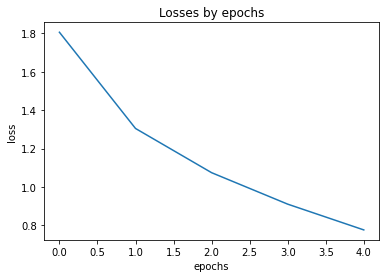

In [23]:
import matplotlib.pyplot as plt
plt.plot(losses_on_epochs)
plt.title("Losses by epochs")
plt.xlabel("epochs")
plt.ylabel("loss")

In [24]:
metric = load_metric("f1")
class_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = class_model(**batch)
    
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average = 'weighted')

{'f1': 0.5686687188780158}

In [41]:
class_model.save_pretrained("C:/Users/sorok/Desktop/")

In [42]:
new_mask_model = ElectraForMaskedLM.from_pretrained("C:/Users/sorok/Desktop/")

Some weights of the model checkpoint at C:/Users/sorok/Desktop/ were not used when initializing ElectraForMaskedLM: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at C:/Users/sorok/Desktop/ and are newly initialized: ['generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_predictions.

In [43]:
fill_mask2 = pipeline(
    'fill-mask',
    model = new_mask_model,
    tokenizer = TOKENIZER_NAME
)

In [48]:
print(fill_mask2("Why don't you ask [MASK]?")[0]['sequence'])

why don't you ask gemini?


In [51]:
print(fill_mask2("What is [MASK]")[0]['sequence'])

what isbas


In [52]:
print(fill_mask2("Let's talk about [MASK] physics")[0]['sequence'])

let's talk about inquired physics


In [54]:
print(fill_mask2("Let's talk about [MASK] physics"))

[{'score': 0.0003597834147512913, 'token': 24849, 'token_str': 'inquired', 'sequence': "let's talk about inquired physics"}, {'score': 0.0002826803538482636, 'token': 4596, 'token_str': 'dinner', 'sequence': "let's talk about dinner physics"}, {'score': 0.00026624195743352175, 'token': 4977, 'token_str': 'turkey', 'sequence': "let's talk about turkey physics"}, {'score': 0.00026534197968430817, 'token': 17413, 'token_str': '##cky', 'sequence': "let's talk aboutcky physics"}, {'score': 0.0002448171435389668, 'token': 22878, 'token_str': 'midday', 'sequence': "let's talk about midday physics"}]


In [ ]:
# With the selected hyperparameters it was possible to achieve f1 = 56 score which is decent, classification is successful.
# It seems like the resulted mask model is kinda random. It have too low % chances for specific words.
# This may occur because I trained the whole model and not just the extra layer. The model focused on learning
# the classification task and mixed all weights and biases for the mask model, thus it doesn't work anymore.